# DeepDream

DeepDream is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image. This code is a minimal implementation of DeepDream as described by Alexander Mordvintsev in his blog post.

In [0]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Utility Functions


In [0]:
def deprocess_img(img):
  img = 255*(img + 1) / 2
  return tf.cast(img, dtype=tf.uint8)

def show_img(img, title="Generated Image"):
  if len(img.shape) > 3:
    img = tf.squeeze(img, axis=0)

  plt.title(title)
  plt.imshow(img)

def show_tensor_as_img(tensor, title="Generated Image"):
  img = tensor.numpy()
  img = deprocess_img(img)
  show_img(img, title)

def save_img(img, img_path):
  if len(img.shape) > 3:
    img = tf.squeeze(img, axis=0)

  img = deprocess_img(img)
  tf.keras.preprocessing.image.save_img(img_path, img)

def clip_img(img, min_val=-1, max_val=1):
  return tf.clip_by_value(img, min_val, max_val, name="clipping_img")

def scale_img(img, max_size=512):
  shape = tf.cast(img.shape[:-1], dtype=tf.float32)
  max_dim = max(shape)
  scale = tf.constant(max_size / max_dim, dtype=tf.float32)
  new_shape = tf.cast(shape * scale, dtype=tf.int32)
  resized_img = tf.image.resize(img, new_shape, name="resizing_img")
  return resized_img[tf.newaxis, :]

def prepare_img(img_path, img_name="input_img"):
  raw_img = tf.io.read_file(img_path)
  img = tf.io.decode_image(raw_img, channels=3, dtype=tf.float32, name=img_name)
  scaled_img = scale_img(img)
  return scaled_img

# Model Definition & Losses

 The loss is the sum of the activations in the choosen layers. The loss is normalized so that each layer contribute equally. Normally, we run gradient descent to minimize loss but here we will try to maximize it, this is because we want our model to go wrong and bizzare to generate new images. 

In [0]:
def calculate_loss(layer_activations):
  losses = [tf.reduce_mean(activation) for activation in layer_activations]
  return tf.reduce_sum(losses)

In [0]:
def train_step(img, model, step_size=0.01):
  with tf.GradientTape() as tape:
    tape.watch(img)
    layer_activations = deep_dream(img)
    loss = calculate_loss(layer_activations)
  
  gradients = tape.gradient(loss, img)
  # Normalizing the gradients
  gradients /= tf.math.reduce_std(gradients) + 1e-8
  img = img + gradients * step_size
  img = clip_img(img)
  return loss, img

We will use a pre-trained network image classification network known as InceptionV3 which is similar to the model used in original DeepDream. However, any pre-trained can work.

In [0]:
class DeepDream(tf.keras.Model):

  def __init__(self, pre_trained_model, layer_list):
    super(DeepDream, self).__init__()
    layer_outputs = [pre_trained_model.get_layer(name).output 
                     for name in layer_list]
    self.custom_model = tf.keras.Model(pre_trained_model.input, layer_outputs)
    # Making sure we are not training our pre-trained network
    pre_trained_model.trainable = False
  def call(self, img):
    return self.custom_model(img)

# Model Initialization & Layers Definition

In [0]:
# Loading InceptionV3 network
inceptionV3 = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Defining our magical layers
layers = ["mixed1", "mixed4", "mixed5", "mixed10"]

# Let's Make Network Start Dreaming

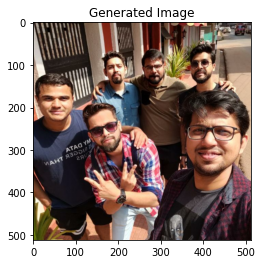

In [110]:
# Loading our image
img = prepare_img("/content/dost.jpeg")
img = tf.keras.applications.inception_v3.preprocess_input(img*255)
show_tensor_as_img(img)

# Creating object our model
deep_dream = DeepDream(inceptionV3, layers)

# Training

In [0]:
# Defining hyper-parameters
iterations = 200
step_size = 0.01

for i in range(1, iterations+1):
  loss, img = train_step(img, deep_dream, step_size)
  if i % 20 == 0:
    print(f"Loss after {i} iterations is: {loss:.4f}")
    save_img(img, f"/content/gen_{i}.jpg")

Loss after 20 iterations is: 2.8860
Loss after 40 iterations is: 3.8272
Loss after 60 iterations is: 4.5620
